# Scaled Interval Score

This is the average Winkler score divided by the one step insample Naive1 or SNaive

Sources: 
* https://www.sciencedirect.com/science/article/pii/S0169207019301128
* https://www.tandfonline.com/doi/abs/10.1198/016214506000001437

> This notebook also contains a numpy implementation of calculating the mean winkler score.  This has very minor performance benefits that increase as the n of points falling outside the interval increase.

## Imports

In [1]:
import pandas as pd
import numpy as np

from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.metrics import mean_absolute_error
from forecast_tools.datasets import load_emergency_dept

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    data - arraylike - the training data
    preds - numpy.array, vector of predictions 
    
    Returns:
    -------
    pandas.DataFrame
    '''
    start = pd.date_range(start=data.index.max(), periods=2, 
                          freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [3]:
def plot_prediction_intervals(train, preds, intervals, 
                              test=None, show_train_size=None, figsize=(12,4)):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    
    if show_train_size is None:
        show_train_size = len(train)
        
    train = train[-show_train_size:]
    ax = train.plot(figsize=figsize)
    

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                   '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black', marker='o', ls='')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', 
                   '_ignore','_ignore', '90%PI'], loc=2)

## Individual and mean interval score

In [4]:
def winkler_score(l_interval, u_interval, y_t, alpha):
    '''
    Calculates the Winkler score for an observation in 
    an prediction interval.
    
    Winkler scores penalise intervals that do not capture the 
    observation proportional to 2/alpha

    Params:
    -------
    l_interval: float
        Lower prediction interval
        
    u_interval: float
        Upper prediction interval
        
    y_t: float
        Observed ground truth value
        
    alpha: float
        The prediction interval alpha.  For an 80% pred intervals alpha=0.2
        
    Returns:
    -------
    float
    
    Example usage:
    --------------
    ```python
    >>> alpha = 0.2
    >>> interval = [744.54, 773.22]
    >>> y_t = 741.84
    >>> ws = winkler_score(interval, y_t, alpha)
    >>> print(round(ws, 2))
    
    56.68
    ```
    '''
    score = u_interval - l_interval
    if y_t < l_interval:
        score += ((2/alpha) * (l_interval - y_t))
    elif y_t > u_interval:
        score += ((2/alpha) * (y_t - u_interval))
    return score

In [5]:
def mean_winkler_score(intervals, observations, alpha):
    '''
    Returns the mean winkler score across a set of 
    intervals and also a numpy.ndarray of individual winkler scores
    
    Params:
    -------
    intervals: array-like
        array of prediction intervals
        
    observations: array-like
        array of ground truth observations
        
    alpha: float
        The prediction interval alpha.  For an 80% pred intervals alpha=0.2
        
    Returns:
    -------
    float, numpy.ndarray
    
    '''
    observations = np.array(observations)
    scores = [winkler_score(l[0], l[1], y_t[0], alpha) 
              for l, y_t in zip(intervals, observations)]
    scores = np.array(scores)
    return scores.mean()

In [21]:
def mean_winkler_score_np(intervals, observations, alpha):
    '''
    Returns the mean winkler score across a set of 
    intervals and also a numpy.ndarray of individual winkler scores.
    
    Numpy Implementation
    
    Params:
    -------
    intervals: array-like
        array of prediction intervals
        
    observations: array-like
        array of ground truth observations
        
    alpha: float
        The prediction interval alpha.  For an 80% pred intervals alpha=0.2
        
    Returns:
    -------
    float, numpy.ndarray
    
    '''
    observations = np.array(observations).T[0]
    
    # interval widths
    scores = intervals[:, 1] - intervals[:, 0]
    
    # observation falls below lower interval
    below_lower = observations < intervals[:, 0]
    
    # observation exceeds upper interval
    above_upper = observations > intervals[:, 1]
    
    # lower penality
    scores[below_lower] += \
        ((2/alpha) * (intervals[:, 0][below_lower] - observations[below_lower]))
                            
    # upper penality
    scores[above_upper] += \
        ((2/alpha) * (observations[above_upper] - intervals[:, 1][above_upper]))
    
    return scores.mean()

## Scaled interval score implementation

In [7]:
def scaled_interval_score_np(y_true, intervals, y_train, alpha, period=None):
    '''
    Mean interval score / one step naive forecast.
    
    Uses numpy implementation of mean interval score.
    '''
    y_true, y_train = np.array(y_true), np.array(y_train)
    
    if period is None:
        period = 1
        
    in_sample_model = SNaive(period=period)
    in_sample_model.fit(y_train)

    mae_insample = mean_absolute_error(y_train[period:],
                                       in_sample_model.fittedvalues.dropna())
    
    return mean_winkler_score_np(intervals, y_true, alpha) / mae_insample

In [8]:
def scaled_interval_score(y_true, intervals, y_train, alpha, period=None):
    '''
    Mean interval score / one step naive forecast.
    
    Standar python implementation.
    '''
    y_true, y_train = np.array(y_true), np.array(y_train)
    
    if period is None:
        period = 1
        
    in_sample_model = SNaive(period=period)
    in_sample_model.fit(y_train)

    mae_insample = mean_absolute_error(y_train[period:],
                                       in_sample_model.fittedvalues.dropna())
    
    return mean_winkler_score(intervals, y_true, alpha) / mae_insample

## Example with outpatient dataset

In [9]:
TARGET = 0.80
HOLDOUT = 6
URL = 'https://raw.githubusercontent.com/health-data-science-OR/' \
        + 'hpdm097-datasets/master/out_appoints_mth.csv'

appoints = pd.read_csv(URL, index_col='date', parse_dates=True, dayfirst=True)
appoints.index.freq = 'MS'

# train-test split
train = appoints[:-HOLDOUT]
test_out = appoints[-HOLDOUT:]

model = Naive1()

# returns 80 and 90% prediction intervals by default.
model.fit(train)
preds, intervals_out = model.predict(6, return_predict_int=True)

In [10]:
msis = scaled_interval_score_np(test_out, intervals_out[0], train, 
                                alpha=1-TARGET, period=12)
print(msis)

6.51227581009931


In [11]:
msis = scaled_interval_score(test_out, intervals_out[0], train, 
                             alpha=1-TARGET, period=12)
print(msis)

6.51227581009931


## Example with `forecast_tools` ED dataset

In [12]:
TARGET = 0.80
HOLDOUT = 14
PERIOD = 7

attends = load_emergency_dept()

# train-test split
train = attends[:-HOLDOUT]
test_ed = attends[-HOLDOUT:]

model = SNaive(PERIOD)

# returns 80 and 90% prediction intervals by default.
preds, intervals_ed = model.fit_predict(train, HOLDOUT, return_predict_int=True)

msis = scaled_interval_score_np(test_ed, intervals_ed[0], 
                             train, alpha=1-TARGET, period=PERIOD)
print(f'Mean scaled interval score: {msis}')

Mean scaled interval score: 2.8561684111471703


In [13]:
%timeit msis = scaled_interval_score(test_ed, intervals_ed[0], train, alpha=1-TARGET, period=PERIOD)

1.16 ms ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit msis = scaled_interval_score_np(test_ed, intervals_ed[0], train, alpha=1-TARGET, period=PERIOD)
#print(f'Mean scaled interval score: {msis}')

1.14 ms ± 6.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


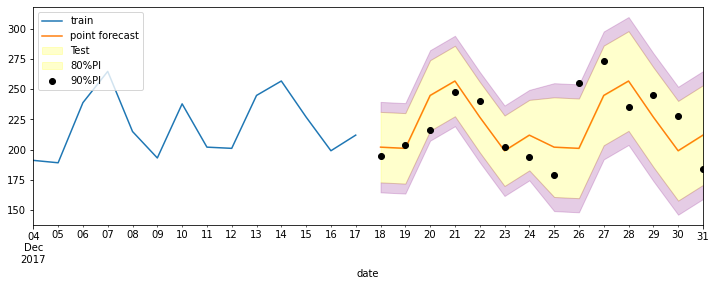

In [15]:
plot_prediction_intervals(train, preds, intervals_ed, test=test_ed, show_train_size=14)

In [20]:
TARGET = 0.80
HOLDOUT = 48
URL = 'https://raw.githubusercontent.com/health-data-science-OR/' \
    + 'hpdm097-datasets/master/Alcohol_Sales.csv'

sales = pd.read_csv(URL, index_col='DATE', parse_dates=True, dayfirst=True)
sales.index.freq = 'MS'

# train-test split
train = sales[:-HOLDOUT]
test_sales = sales[-HOLDOUT:]

model = SNaive(12)

# returns 80 and 90% prediction intervals by default.
model.fit(train)
preds, intervals_sales = model.predict(HOLDOUT, return_predict_int=True)

msis = scaled_interval_score_np(test_sales, intervals_sales[0], 
                             train, alpha=1-TARGET, period=PERIOD)
print(f'Mean scaled interval score for 80% PIs: {msis:.2f}')

Mean scaled interval score for 80% PIs: 2.89


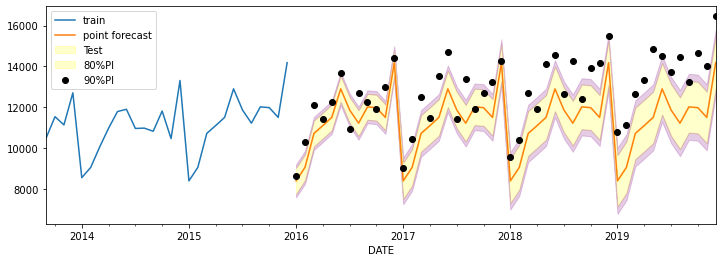

In [17]:
plot_prediction_intervals(train, preds, intervals_sales, test=test_sales, 
                          show_train_size=28)